In [42]:
import csv
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import os

In [43]:
gt_ts = []
gt_x = []
gt_y = []
gt_z = []
gt_qx = []
gt_qy = []
gt_qz = []
gt_qw = []

with open("/data/mustard_translation_x_2ms/ground_truth.csv", "r") as file:
    reader = csv.reader(file)
    for row in reader:
        gt_ts.append(float(row[0]))
        gt_x.append(float(row[1])*0.01)
        gt_y.append(float(row[2])*0.01)
        gt_z.append(float(row[3])*0.01)
        gt_qx.append(float(row[4]))
        gt_qy.append(float(row[5]))
        gt_qz.append(float(row[6]))
        gt_qw.append(float(row[7]))

gt_ts = np.array(gt_ts) - gt_ts[0]

# gt_roll, gt_pitch, gt_yaw = quaternions_to_rpy(gt_qx, gt_qy, gt_qz, gt_qw)  

# the initial state is assumed to be known: the tracker computes the variation
# roll = gt_roll[0] + roll
# pitch = gt_pitch[0] + pitch
# yaw = gt_yaw[0] + yaw


In [44]:
def compute_aligned_difference(ts1, values1, ts2, values2):
    """
    Interpolates values2 to match timestamps ts1, and computes absolute differences.

    Args:
        ts1 (array-like): Target timestamps.
        values1 (array-like): Values at ts1.
        ts2 (array-like): Source timestamps to interpolate from.
        values2 (array-like): Values at ts2.

    Returns:
        np.array: Absolute difference between values1 and interpolated values2.
    """
    # Interpolate values2 to match timestamps ts1
    interp_func = interp1d(ts2, values2, kind='linear', bounds_error=False, fill_value="extrapolate")
    interpolated_values2 = interp_func(ts1)

    # Compute absolute difference
    differences = np.abs(np.array(values1) - interpolated_values2)

    return differences

def find_first_sustained_exceedance(error, threshold, consecutive_count):
    """
    Find the first index where `consecutive_count` values in a row exceed `threshold`.

    Args:
        error (array-like): Sequence of error values.
        threshold (float): Threshold value.
        consecutive_count (int): Minimum number of consecutive values that must exceed the threshold.

    Returns:
        int or None: Starting index of the first sustained exceedance, or None if not found.
    """
    error = np.array(error) > threshold
    count = 0
    for i, val in enumerate(error):
        if val:
            count += 1
            if count == consecutive_count:
                return i - consecutive_count + 1
        else:
            count = 0
    return None


None


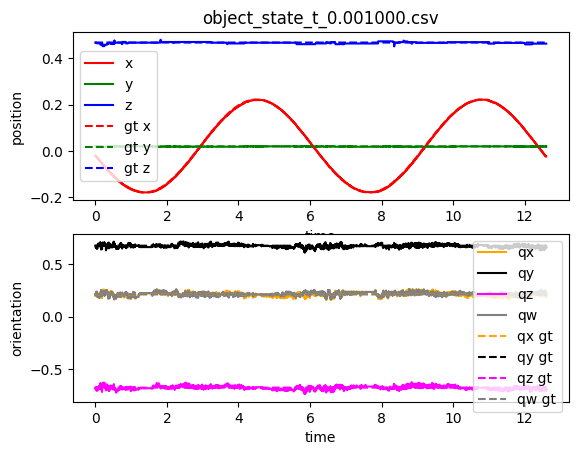

None


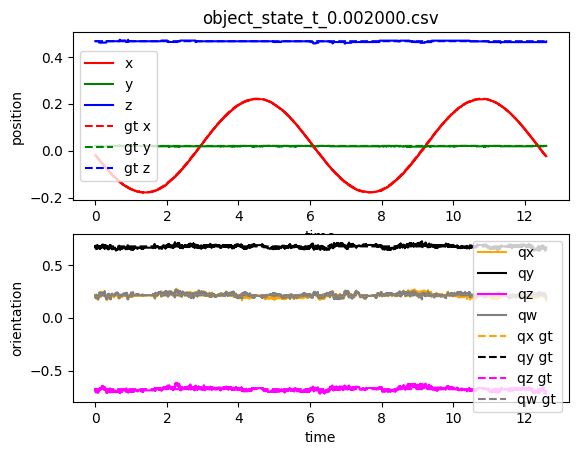

1499


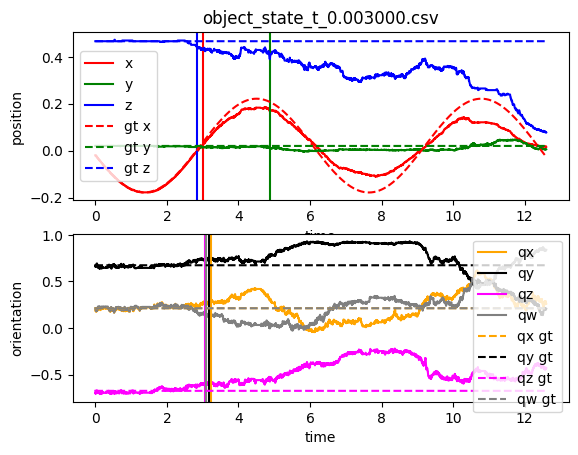

4643


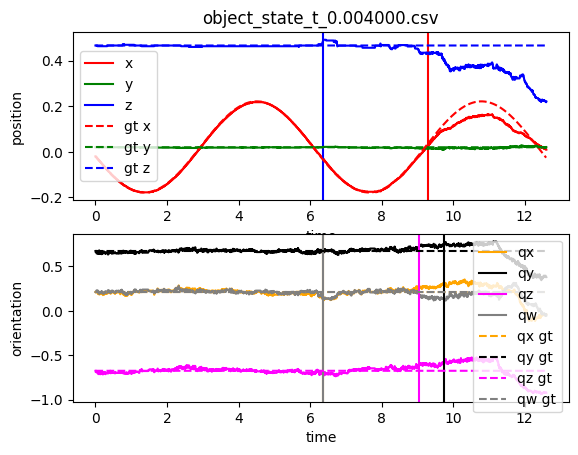

1419


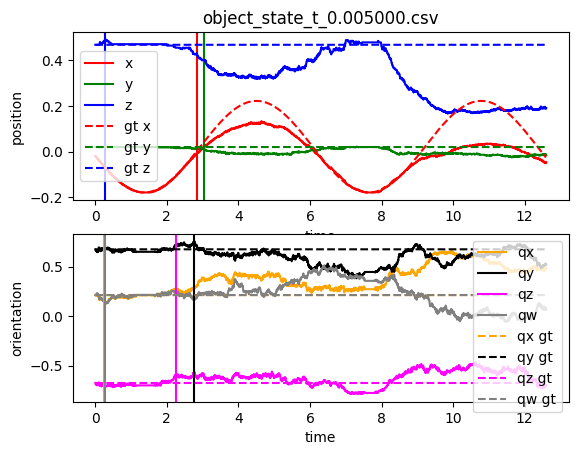

1304


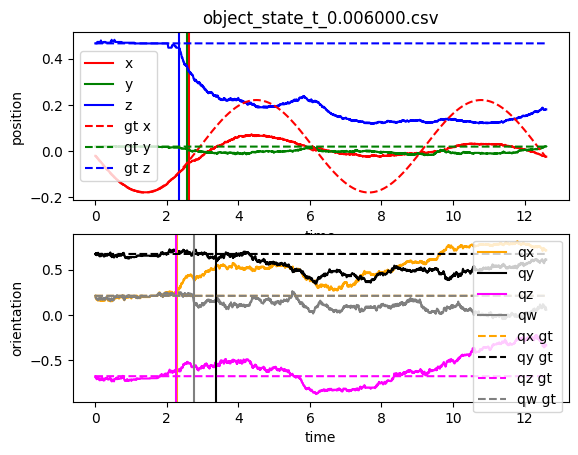

1279


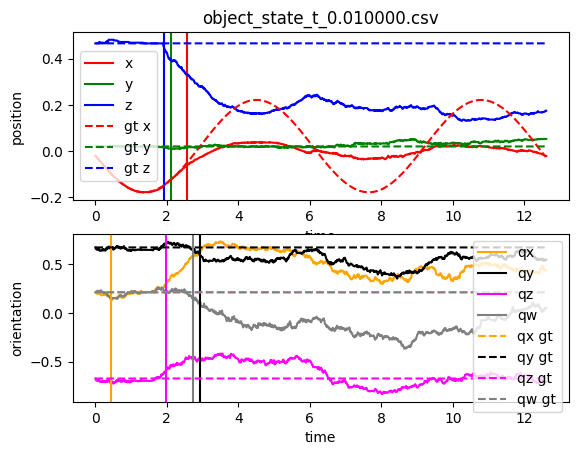

[np.float64(12.597810745239258), np.float64(12.597810745239258), np.float64(2.9977827072143555), np.float64(9.285326957702637), np.float64(2.837794303894043), np.float64(2.6078109741210938), np.float64(2.557814598083496)]


In [45]:
results_folder = "/data/six-dof-time-window/"
files = sorted([
    f for f in os.listdir(results_folder)
    if os.path.isfile(os.path.join(results_folder, f))
])

failure_times = []

for filename in files:
    ts = []
    x = []
    y = []
    z = []
    qx = []
    qy = []
    qz = []
    qw = []
    time_windows = [1, 2, 3, 4, 5, 6, 10]

    file_path = os.path.join(results_folder, filename)
    with open(file_path, "r") as file:
        reader = csv.reader(file)
        for row in reader:
            ts.append(float(row[0]))
            x.append(float(row[1]))
            y.append(float(row[2]))
            z.append(float(row[3]))
            qx.append(float(row[4]))
            qy.append(float(row[5]))
            qz.append(float(row[6]))
            qw.append(float(row[7]))

        x_abs_diff = compute_aligned_difference(gt_ts, gt_x, ts, x)
        y_abs_diff = compute_aligned_difference(gt_ts, gt_y, ts, y)
        z_abs_diff = compute_aligned_difference(gt_ts, gt_z, ts, z)

        qx_abs_diff = compute_aligned_difference(gt_ts, gt_qx, ts, qx)
        qy_abs_diff = compute_aligned_difference(gt_ts, gt_qy, ts, qy)
        qz_abs_diff = compute_aligned_difference(gt_ts, gt_qz, ts, qz)
        qw_abs_diff = compute_aligned_difference(gt_ts, gt_qw, ts, qw)

        index_x = find_first_sustained_exceedance(x_abs_diff, 0.01, 10)
        index_y = find_first_sustained_exceedance(y_abs_diff, 0.01, 10)
        index_z = find_first_sustained_exceedance(z_abs_diff, 0.02, 10)

        index_qx = find_first_sustained_exceedance(qx_abs_diff, 0.07, 10)
        index_qy = find_first_sustained_exceedance(qy_abs_diff, 0.07, 10)
        index_qz = find_first_sustained_exceedance(qz_abs_diff, 0.07, 10)
        index_qw = find_first_sustained_exceedance(qw_abs_diff, 0.07, 10)

        if index_x == None:
            failure_times.append(gt_ts[-1])
        else:    
            failure_times.append(gt_ts[index_x])

        %matplotlib inline

        fig,ax = plt.subplots(2,1)

        ax[0].plot(np.array(ts), np.array(x), label="x", color="red")
        print(index_x)
        if index_x != None:
            ax[0].axvline(x = gt_ts[index_x], color='red')
        if index_y != None:
            ax[0].axvline(x = gt_ts[index_y], color='green')
        if index_z != None:
            ax[0].axvline(x = gt_ts[index_z], color='blue')
        ax[0].plot(np.array(ts), np.array(y), label="y", color="green")
        ax[0].plot(np.array(ts), np.array(z), label="z", color="blue")

        ax[0].plot(gt_ts, np.array(gt_x), label="gt x", color="red", linestyle="dashed")
        ax[0].plot(gt_ts, np.array(gt_y), label="gt y", color="green", linestyle="dashed")
        ax[0].plot(gt_ts, np.array(gt_z), label="gt z", color="blue", linestyle="dashed")

        ax[0].set_xlabel("time")
        ax[0].set_ylabel("position")
        ax[0].legend()

        ax[1].plot(ts, qx, label="qx", color='orange')
        ax[1].plot(ts, qy, label="qy", color='black')
        ax[1].plot(ts, qz, label="qz", color='magenta')
        ax[1].plot(ts, qw, label="qw", color='grey')

        if index_qx != None:
            ax[1].axvline(x = gt_ts[index_qx], color='orange')
        if index_qy != None:
            ax[1].axvline(x = gt_ts[index_qy], color='black')
        if index_qz != None:
            ax[1].axvline(x = gt_ts[index_qz], color='magenta')
        if index_qw != None:
            ax[1].axvline(x = gt_ts[index_qw], color='grey')

        ax[1].plot(gt_ts, gt_qx, label="qx gt", color='orange', linestyle="dashed")
        ax[1].plot(gt_ts, gt_qy, label="qy gt", color='black', linestyle="dashed")
        ax[1].plot(gt_ts, gt_qz, label="qz gt", color='magenta', linestyle="dashed")
        ax[1].plot(gt_ts, gt_qw, label="qw gt", color='grey', linestyle="dashed")

        ax[1].set_xlabel("time")
        ax[1].set_ylabel("orientation")
        ax[1].legend()

        ax[0].set_title(filename)
        plt.show()

        # fig.savefig('/usr/local/src/EDOPT/scripts/traj.png')
        # print("Saved successfully!")  

print(failure_times)

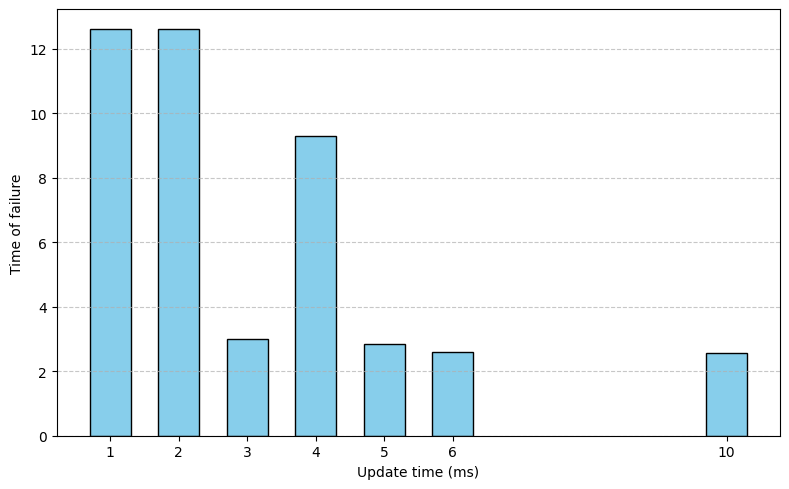

In [46]:
plt.figure(figsize=(8, 5))
plt.bar(time_windows, failure_times, width=0.6, color='skyblue', edgecolor='black')

plt.xlabel('Update time (ms)')
plt.ylabel('Time of failure')
plt.xticks(time_windows)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()